# Backtesting A Trading Strategy Part 3

## How to Backtest A Mean-reverting Trading Strategy Using Python

## Introduction
Backtesting is a tool to measure the performance of a trading strategy using historical data. The backtesting process consists of three parts: 1. determining the universe of securities where we will invest in (e.g. equity or fixed income? US or emerging markets?); 2. gathering historical data for the universe of securities; and 3. implementing a trading strategy using the historical data collected.  

In the previous articles, I illustrated the first two steps in the backtesting process of determining the universe of stocks, and collecting historical data for each constituent. In this article, I will illustrate the last step of the process: implementing a mean-reverting trading strategy.

## A Mean-reverting Trading Strategy
We implement a mean-reverting trading strategy based on [Khandani and Lo](http://web.mit.edu/Alo/www/Papers/august07.pdf). The idea is to buy the previous day's "losers", and sell the previous day's "winners". Stocks which underperform the market average are classified as "losers"; while stocks which outperform the market average are classified as "winners".

For each stock $i$, we calculate the weight $w_{i, t}$ at time $t$

$$ w_{i, t} = - \frac{1}{N} \left( r_{i, t-1} - r_{Market, t-1} \right). $$

where $N$ is the total number of stocks in the investment universe. Market return at time $t-1$ is calculated as

$$ r_{Market, t-1} = \frac{1}{N} \sum_{i=1}^{N} r_{i, t-1}, $$

and return of stock $i$ at time $t-1$ is calculated as

$$ r_{i, t-1} = \frac{S_{i, t-1} - S_{i, t-2}}{S_{i, t-2}}, $$

where $S_{i, t-1}$ is the spot price of stock $i$ at time $t-1$.

## Backtesting A Trading Strategy
### Step By Step
1. Load S&P indices historical data.
2. Implement a mean-reverting trading strategy.
3. Calculate the trading strategy's performance using the Sharpe ratio.

You can find the code on https://github.com/DinodC/backtesting-trading-strategy.

Import packages

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Load S&P Historical Data

Set an id for each index

In [2]:
id = ['sp500', 'sp400', 'sp600']

Create a dictionary to map each id to a tickers file

In [3]:
input_file = {'sp500': 'sp500_data.pickle',
              'sp400': 'sp400_data.pickle',
              'sp600': 'sp600_data.pickle'}

Create a dictionary to map each id to a S&P historical data

In [4]:
sp500_data = pd.DataFrame()
sp400_data = pd.DataFrame()
sp600_data = pd.DataFrame()
sp_data = {'sp500': sp500_data,
           'sp400': sp400_data,
           'sp600': sp600_data}

Retrieve S&P historical data

In [5]:
for i in id:
    # Load data 
    with open(input_file[i], 'rb') as f:
        sp_data[i] = pickle.load(f)
    f.close()
    
    # Select close prices
    sp_data[i] = sp_data[i].close

### Implement A Mean-reverting Trading Strategy

Create a dictionary to map each id to a S&P returns data

In [6]:
sp500_returns = DataFrame()
sp400_returns = DataFrame()
sp600_returns = DataFrame()
sp_returns = {'sp500': sp500_returns,
              'sp400': sp400_returns,
              'sp600': sp600_returns}

Create a dictionary to map each id to a S&P market returns data

In [7]:
sp500_market_returns = Series()
sp400_market_returns = Series()
sp600_market_returns = Series()
sp_market_returns = {'sp500': sp500_market_returns,
                     'sp400': sp400_market_returns,
                     'sp600': sp600_market_returns}

Create a dictionary to map each id to a trading strategy weighting

In [8]:
sp500_weights = DataFrame()
sp400_weights = DataFrame()
sp600_weights = DataFrame()
sp_weights = {'sp500': sp500_weights,
              'sp400': sp400_weights,
              'sp600': sp600_weights}

Create a dictionary to map each id to a trading strategy pnl per stock

In [9]:
sp500_pnl = DataFrame()
sp400_pnl = DataFrame()
sp600_pnl = DataFrame()
sp_pnl = {'sp500': sp500_pnl,
          'sp400': sp400_pnl,
          'sp600': sp600_pnl}

Create a dictionary to map each id to a trading strategy pnl

In [10]:
sp500_pnl_net = Series()
sp400_pnl_net = Series()
sp600_pnl_net = Series()
sp_pnl_net = {'sp500': sp500_pnl_net,
              'sp400': sp400_pnl_net,
              'sp600': sp600_pnl_net}

Implement the mean-reverting trading strategy on stock universes: S&P 500, S&P MidCap 400, and S&P SmallCap indices

In [11]:
for i in id:
    # Calculate the returns
    sp_returns[i] = sp_data[i].pct_change()
    
    # Calculate the equally weighted market returns
    sp_market_returns[i] = sp_returns[i].mean(axis='columns')
    
    # Calculate the weights of each stock
    sp_weights[i] = - (sp_returns[i].sub(sp_market_returns[i], axis='index')).div(sp_data[i].count(axis='columns'), axis='index')
    
    # Adjust the weights to 0 if price or return is NaN
    sp_weights[i][sp_data[i].isna() | sp_data[i].shift(periods=1).isna()] = 0
    
    # Calculate the daily pnl
    # Idea is to buy yesterday's losers, and sell yesterday's winners
    sp_pnl[i] = (sp_weights[i].shift(periods=1)).mul(sp_returns[i], axis='index')
    sp_pnl_net[i] = sp_pnl[i].sum(axis='columns')

### Calculate The Performance Metrics Of A Trading Strategy
In this section, I will provide a brief review of the Sharpe ratio which is a popular measure of a trading strategy's performance. The Sharpe ratio is a special case of the more generic Information ratio (IR). Consequently, I will present the IR first, and followed by the illustration on the Sharpe ratio.

#### Information Ratio
The Information ratio measures the excess returns of a trading strategy over a benchmark, such as the S&P 500 index. The IR scales the excess returns with the standard deviation to measure the consistency of the trading strategy. We calculate the Information ratio using the formula

$$ IR = \frac{r_{Strategy} - r_{Benchmark}}{\sigma_{Strategy}}. $$

In practice, we usually calculate the annualized IR as follows:
1. Calculate the average and standard deviation of daily returns 
2. Annualize the two metrics
3. Compute the annualized return of the benchmark

#### Sharpe Ratio
The Sharpe ratio is a special case of the Information ratio where the benchmark is set to the risk-free rate. It allows for decomposition of a trading strategy's profit and losses into risky and risk-free parts. The Sharpe ratio is popular because it facilitates comparison of different trading strategies using different benchmarks. 

#### How To Calculate The Sharpe Ratio
The Sharpe ratio calculation depends on the trading strategy deployed.

##### Long Only Strategies
For long-only trading strategies, we calculate the Sharpe ratio as

$$ Sharpe = \frac{r_{Long} - r_{Risk-free}}{\sigma_{Long}},  $$

where the $r_{Risk-free}$ is usually obtained from the treasury yield curve.

##### Long And Short Strategies
For long and short strategies holding equal amount of capital on both positions, also known as "dollar-neutral", we have a simpler formula for calculating the Sharpe ratio

$$ Sharpe = \frac{r_{Long-Short}}{\sigma_{Long-Short}}. $$

The $r_{Risk-free}$ disappears in the equation because the cash received from the short positions earns the same risk-free rate.

#### Performance Metrics Of A Mean-Reverting Strategy

Divide the periods of observation

In [12]:
period = ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']

Create a dictionary to map each id to a trading performance

In [13]:
sp500_performance = pd.DataFrame()
sp400_performance = pd.DataFrame()
sp600_performance = pd.DataFrame()
sp_performance = {'sp500': sp500_performance,
                  'sp400': sp400_performance,
                  'sp600': sp600_performance}

Calculate the trading strategy's annualized Sharpe ratio, average daily returns and standard deviation

In [14]:
for i in id:
    # Initialize performance measures
    avg_returns = []
    std_returns = []
    sharpe = []
    
    # Calculate performance measures
    for j in range(len(period) - 1):
        # Period of observation
        start = period[j]
        end = period[j + 1]
        
        # Calculate average daily returns
        avg_returns.append(sp_pnl_net[i][start:end].mean())
        
        # Calculate standard deviation of daily returns
        std_returns.append(sp_pnl_net[i][start:end].std())
        
        # Calculate Sharpe ratio
        sharpe.append(np.sqrt(252) * avg_returns[j] / std_returns[j])
        
    # Update performance measures DataFrame
    sp_performance[i] = pd.DataFrame({'Avg Daily Returns': avg_returns,
                                      'Std Daily Returns': std_returns,
                                      'Sharpe Ratio': sharpe},
                                    index=['2014', '2015', '2016', '2017', '2018'])

#### Comparison Of The Mean-reverting Strategy Using Different Stock Universes

##### Average Of Daily Returns

In [15]:
sp_avg_returns = pd.DataFrame({'S&P 500': (sp_performance['sp500']['Avg Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 400': (sp_performance['sp400']['Avg Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 600': (sp_performance['sp600']['Avg Daily Returns'] * 100).round(4).astype('str') + '%'})

In [16]:
sp_avg_returns

,S&P 500,S&P 400,S&P 600
2014,0.0008%,0.001%,0.0015%
2015,-0.0%,-0.0007%,0.0004%
2016,-0.0001%,-0.0004%,0.001%
2017,0.0008%,0.0009%,0.0016%
2018,0.0004%,0.0004%,0.0004%


##### Standard Deviation Of Daily Returns

In [17]:
sp_std_returns = pd.DataFrame({'S&P 500': (sp_performance['sp500']['Std Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 400': (sp_performance['sp400']['Std Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 600': (sp_performance['sp600']['Std Daily Returns'] * 100).round(4).astype('str') + '%',})

In [18]:
sp_std_returns

,S&P 500,S&P 400,S&P 600
2014,0.0052%,0.0095%,0.0134%
2015,0.0029%,0.0075%,0.0074%
2016,0.0068%,0.0111%,0.0125%
2017,0.0084%,0.0112%,0.0106%
2018,0.0037%,0.004%,0.0049%


##### Sharpe Ratio

In [19]:
sp_sharpe = pd.DataFrame({'S&P 500': sp_performance['sp500']['Sharpe Ratio'],
                          'S&P 400': sp_performance['sp400']['Sharpe Ratio'],
                          'S&P 600': sp_performance['sp600']['Sharpe Ratio']})

In [20]:
sp_sharpe

,S&P 500,S&P 400,S&P 600
2014,2.390120,1.710263,1.750619
2015,-0.136800,-1.462981,0.792153
2016,-0.319971,-0.571037,1.213862
2017,1.535340,1.259538,2.348185
2018,1.813091,1.471477,1.328564


The mean-reverting strategy's Sharpe ratio is highest on the S&P 600 index composed of small-cap stocks. The inverse relationship between profitability and market-capitalization suggests that inefficiencies are more abundant on small-cap stocks. However, be mindful that small-capitalization stocks are less liquid instruments and have higher transactions costs attached when trading them.

##### Profit And Losses

Plot the cumulative pnl of the mean-reverting strategy by investment universe

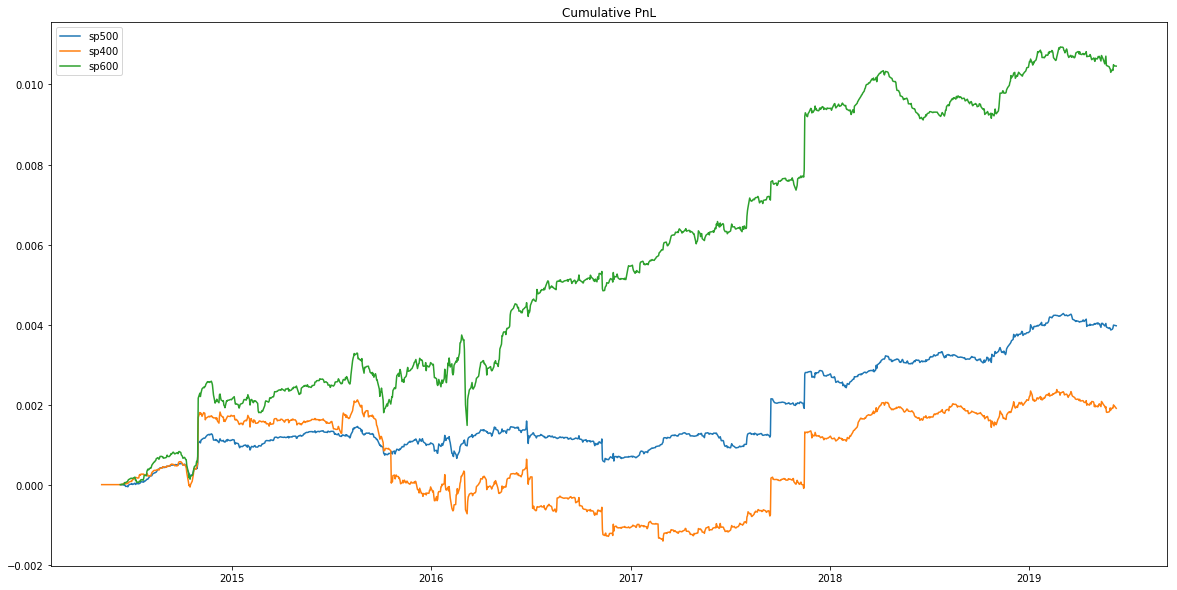

In [21]:
plt.figure(figsize=[20, 10])

plt.plot(sp_pnl_net['sp500'].cumsum())
plt.plot(sp_pnl_net['sp400'].cumsum())
plt.plot(sp_pnl_net['sp600'].cumsum())
plt.title('Cumulative PnL')
plt.legend(id)

### Improvements To The Backtesting Process
The Backtesting process measures the performance of our trading strategy using historical data. We hope that the performance of a trading strategy in the past will reproduce into the future. Unfortunately, such guarantees do not exist.

Our focus should center on rendering the backtesting process as close to reality as possible by including transaction costs, and correcting for the following:
1. Data-snooping bias is the application of an overfitted model in the trading strategy.
2. Look-ahead bias is the use of future data, or data not yet available, in the investment strategy.
3. Survivorship bias is the absence of stocks in the investment universe belonging to companies who went bankrupt, merged or acquired.

## Conclusion
In this article, we implemented a mean-reverting trading strategy and backtested it on our universe of stocks - the S&P 500, S&P MidCap 400 and S&P SmallCap 600 indices. The mean-reverting trading strategy performed best on the S&P 600 index which is composed of small-capitalization stocks. In the next articles, I will illustrate improvements to the backtesting process by including transaction costs, and correcting for potential biasses. 